# Notebook 06 — All Disasters: AdamW + Linear Scheduler (run-3)

This notebook runs the **full 120 experiments** (10 events x 4 budgets x 3 seeds)
using the updated training pipeline with **AdamW optimizer**, **linear LR scheduler**,
and **10% warmup**. Only the **baseline** stopping strategy is used.

Experiments run in **parallel across 2 GPUs** (configurable via `NUM_GPUS` in cell 2).

### What changed vs previous runs

| Setting | run-1 / run-2 | run-3 (this notebook) |
|---|---|---|
| Optimizer | Adam | **AdamW** |
| Weight decay | 0 | **0.01** |
| LR scheduler | None | **Linear with warmup** |
| Warmup ratio | N/A | **0.1** (10% of total steps) |
| Parallel GPUs | 1 (sequential) | **2** |
| Stopping strategy | baseline | baseline |
| Other hyperparams | Paper defaults | Paper defaults |

### Results location

Results are stored in `results/gpt-4o/test/run-3/` with the standard layout:
```
results/gpt-4o/test/run-3/
  {event}/
    {budget}_set{seed}/
      metrics.json
```

### Resume support

Same two-level resume as notebooks 02/03:
1. **Event level**: Events with all 12 `metrics.json` files are skipped entirely.
2. **Experiment level**: Individual `(budget, seed_set)` combinations with existing
   results are skipped within each event.

In [1]:
import json
import statistics
import sys
import time
from pathlib import Path

def _find_repo_root(marker: str = "lg_cotrain") -> Path:
    for candidate in [Path().resolve()] + list(Path().resolve().parents):
        if (candidate / marker).is_dir():
            return candidate
    raise RuntimeError(
        f"Cannot find repo root: no ancestor directory contains '{marker}/'. "
        "Run the notebook from inside the repository."
    )

repo_root = _find_repo_root()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

import matplotlib.pyplot as plt
import numpy as np

from lg_cotrain.run_all import BUDGETS, SEED_SETS, run_all_experiments, format_summary_table

print(f"Repo root: {repo_root}")
print(f"Budgets: {BUDGETS}")
print(f"Seed sets: {SEED_SETS}")
print(f"Experiments per event: {len(BUDGETS) * len(SEED_SETS)}")

Repo root: D:\Workspace\Co-Training
Budgets: [5, 10, 25, 50]
Seed sets: [1, 2, 3]
Experiments per event: 12


In [2]:
# ---- Configuration ----
PSEUDO_LABEL_SOURCE = "gpt-4o"
RUN_NAME = "run-3"

DATA_ROOT = str(repo_root / "data")
RESULTS_ROOT = str(repo_root / "results" / PSEUDO_LABEL_SOURCE / "test" / RUN_NAME)

# Hyperparameters: paper defaults + AdamW weight decay + linear scheduler
STOPPING_STRATEGY = "baseline"
WEIGHT_DECAY = 0.01
WARMUP_RATIO = 0.1

# Multi-GPU: set to the number of GPUs available (1 = sequential)
NUM_GPUS = 2

print(f"Pseudo-label source: {PSEUDO_LABEL_SOURCE}")
print(f"Run name: {RUN_NAME}")
print(f"Results root: {RESULTS_ROOT}")
print(f"Stopping strategy: {STOPPING_STRATEGY}")
print(f"Weight decay: {WEIGHT_DECAY}")
print(f"Warmup ratio: {WARMUP_RATIO}")
print(f"Parallel GPUs: {NUM_GPUS}")

Pseudo-label source: gpt-4o
Run name: run-3
Results root: D:\Workspace\Co-Training\results\gpt-4o\test\run-3
Stopping strategy: baseline
Weight decay: 0.01
Warmup ratio: 0.1
Parallel GPUs: 2


In [3]:
def is_event_complete(event, results_root):
    """Check if all 12 metrics.json files exist for an event."""
    for budget in BUDGETS:
        for seed_set in SEED_SETS:
            path = Path(results_root) / event / f"{budget}_set{seed_set}" / "metrics.json"
            if not path.exists():
                return False
    return True

# Discover events from data directory
data_dir = Path(DATA_ROOT) / "original"
all_events = sorted(p.name for p in data_dir.iterdir() if p.is_dir())

completed_events = [e for e in all_events if is_event_complete(e, RESULTS_ROOT)]
pending_events = [e for e in all_events if e not in completed_events]

print(f"Found {len(all_events)} events total")
print(f"  Completed: {len(completed_events)} ({len(completed_events) * 12} experiments)")
print(f"  Pending:   {len(pending_events)} (up to {len(pending_events) * 12} experiments)")

if completed_events:
    print(f"\nCompleted events (will be skipped):")
    for e in completed_events:
        print(f"  - {e}")

if pending_events:
    print(f"\nPending events (will be run):")
    for e in pending_events:
        print(f"  - {e}")

Found 10 events total
  Completed: 0 (0 experiments)
  Pending:   10 (up to 120 experiments)

Pending events (will be run):
  - california_wildfires_2018
  - canada_wildfires_2016
  - cyclone_idai_2019
  - hurricane_dorian_2019
  - hurricane_florence_2018
  - hurricane_harvey_2017
  - hurricane_irma_2017
  - hurricane_maria_2017
  - kaikoura_earthquake_2016
  - kerala_floods_2018


## Running Experiments

For each pending event, we call `run_all_experiments` with the AdamW
hyperparameters (`weight_decay=0.01`, `warmup_ratio=0.1`) and baseline
stopping strategy.

With `NUM_GPUS=2`, experiments within each event run in parallel across
both GPUs (round-robin assignment). Set `NUM_GPUS=1` for sequential execution.

Individual experiments that already have `metrics.json` are automatically
skipped (useful if the notebook crashed mid-event).

In [4]:
class ProgressTracker:
    """Track global progress across all experiments."""

    def __init__(self, total, already_done, start_time):
        self.total = total
        self.done = already_done
        self.start_time = start_time

    def update(self, event, budget, seed_set, status):
        self.done += 1
        elapsed = time.time() - self.start_time
        pct = 100.0 * self.done / self.total
        elapsed_h = elapsed / 3600

        remaining = self.total - self.done
        if elapsed > 0 and self.done > 0:
            eta_h = (elapsed / self.done) * remaining / 3600
        else:
            eta_h = 0

        print(
            f"[PROGRESS] {self.done}/{self.total} ({pct:.1f}%)"
            f" | Elapsed: {elapsed_h:.2f}h | ETA: {eta_h:.2f}h"
        )

# Count already-completed experiments
already_done = sum(
    1
    for e in all_events
    for b in BUDGETS
    for s in SEED_SETS
    if (Path(RESULTS_ROOT) / e / f"{b}_set{s}" / "metrics.json").exists()
)
total_experiments = len(all_events) * len(BUDGETS) * len(SEED_SETS)

print(f"Total experiments: {total_experiments}")
print(f"Already completed: {already_done}")
print(f"Remaining: {total_experiments - already_done}")

all_event_results = {}
overall_start = time.time()
tracker = ProgressTracker(total_experiments, already_done, overall_start)

# Run pending events
for i, event in enumerate(pending_events, 1):
    print(f"\n{'=' * 60}")
    print(f"Event {i}/{len(pending_events)}: {event}")
    print(f"{'=' * 60}")

    results = run_all_experiments(
        event,
        num_gpus=NUM_GPUS,
        pseudo_label_source=PSEUDO_LABEL_SOURCE,
        stopping_strategy=STOPPING_STRATEGY,
        weight_decay=WEIGHT_DECAY,
        warmup_ratio=WARMUP_RATIO,
        data_root=DATA_ROOT,
        results_root=RESULTS_ROOT,
        _on_experiment_done=tracker.update,
    )
    all_event_results[event] = results

    print()
    print(format_summary_table(results, event))

# Load results for already-completed events
for event in completed_events:
    results = []
    for budget in BUDGETS:
        for seed_set in SEED_SETS:
            path = Path(RESULTS_ROOT) / event / f"{budget}_set{seed_set}" / "metrics.json"
            with open(path) as f:
                results.append(json.load(f))
    all_event_results[event] = results

overall_elapsed = time.time() - overall_start
print(f"\n{'=' * 60}")
print(f"All events done in {overall_elapsed / 3600:.2f}h")
print(f"Total events with results: {len(all_event_results)}")

Total experiments: 120
Already completed: 0
Remaining: 120

Event 1/10: california_wildfires_2018
Running 12 experiments in parallel across 2 GPUs...
[PROGRESS] 1/120 (0.8%) | Elapsed: 0.22h | ETA: 25.94h
[PROGRESS] 2/120 (1.7%) | Elapsed: 0.33h | ETA: 19.28h
[PROGRESS] 3/120 (2.5%) | Elapsed: 0.54h | ETA: 21.04h
[PROGRESS] 4/120 (3.3%) | Elapsed: 0.54h | ETA: 15.70h
[PROGRESS] 5/120 (4.2%) | Elapsed: 0.76h | ETA: 17.58h
[PROGRESS] 6/120 (5.0%) | Elapsed: 0.83h | ETA: 15.83h
[PROGRESS] 7/120 (5.8%) | Elapsed: 1.04h | ETA: 16.81h
[PROGRESS] 8/120 (6.7%) | Elapsed: 1.05h | ETA: 14.66h
[PROGRESS] 9/120 (7.5%) | Elapsed: 1.25h | ETA: 15.46h
[PROGRESS] 10/120 (8.3%) | Elapsed: 1.33h | ETA: 14.60h
[PROGRESS] 11/120 (9.2%) | Elapsed: 1.54h | ETA: 15.22h
[PROGRESS] 12/120 (10.0%) | Elapsed: 1.54h | ETA: 13.85h

Batch complete: 12 ran, 0 skipped, 0 failed (5541.5s total)

=== Results for california_wildfires_2018 ===

Budget    Seed 1              Seed 2              Seed 3                  Mea

## Cross-Disaster Results

We now aggregate results across all events to compare how the pipeline
performs with AdamW on different disaster types and how performance scales
with the labeled data budget.

In [5]:
# Build cross-disaster summary: event -> budget -> mean macro-F1
summary = {}
for event in sorted(all_event_results.keys()):
    results = all_event_results[event]
    by_budget = {b: [] for b in BUDGETS}
    for r in results:
        if r is not None:
            by_budget[r["budget"]].append(r)
    summary[event] = {}
    for b in BUDGETS:
        f1s = [r["test_macro_f1"] for r in by_budget[b]]
        errs = [r["test_error_rate"] for r in by_budget[b]]
        summary[event][b] = {
            "f1_mean": statistics.mean(f1s) if f1s else None,
            "f1_std": statistics.stdev(f1s) if len(f1s) >= 2 else None,
            "err_mean": statistics.mean(errs) if errs else None,
            "err_std": statistics.stdev(errs) if len(errs) >= 2 else None,
            "n_seeds": len(f1s),
        }

# Print grand summary table
header = f"{'Event':<35}"
for b in BUDGETS:
    header += f" | B={b:<11}"
print(header)
print("-" * len(header))

for event in sorted(summary.keys()):
    row = f"{event:<35}"
    for b in BUDGETS:
        s = summary[event][b]
        if s["f1_mean"] is not None and s["f1_std"] is not None:
            row += f" | {s['f1_mean']:.3f}+/-{s['f1_std']:.3f}"
        elif s["f1_mean"] is not None:
            row += f" | {s['f1_mean']:.3f}      "
        else:
            row += f" | {'N/A':<11}"
    print(row)

# Grand mean across all events
print()
grand_row = f"{'GRAND MEAN':<35}"
for b in BUDGETS:
    all_f1 = [summary[e][b]["f1_mean"] for e in summary if summary[e][b]["f1_mean"] is not None]
    if all_f1:
        grand_row += f" | {statistics.mean(all_f1):.3f}      "
    else:
        grand_row += f" | {'N/A':<11}"
print(grand_row)

Event                               | B=5           | B=10          | B=25          | B=50         
---------------------------------------------------------------------------------------------------
california_wildfires_2018           | 0.608+/-0.004 | 0.607+/-0.003 | 0.592+/-0.011 | 0.648+/-0.006
canada_wildfires_2016               | 0.562+/-0.004 | 0.568+/-0.021 | 0.590+/-0.021 | 0.570+/-0.013
cyclone_idai_2019                   | 0.499+/-0.033 | 0.559+/-0.045 | 0.561+/-0.034 | 0.535+/-0.010
hurricane_dorian_2019               | 0.512+/-0.034 | 0.549+/-0.024 | 0.570+/-0.017 | 0.596+/-0.013
hurricane_florence_2018             | 0.635+/-0.006 | 0.648+/-0.007 | 0.671+/-0.021 | 0.690+/-0.016
hurricane_harvey_2017               | 0.620+/-0.003 | 0.636+/-0.015 | 0.653+/-0.008 | 0.662+/-0.004
hurricane_irma_2017                 | 0.617+/-0.012 | 0.622+/-0.006 | 0.632+/-0.008 | 0.657+/-0.003
hurricane_maria_2017                | 0.658+/-0.003 | 0.657+/-0.005 | 0.672+/-0.003 | 0.676+/-0.001


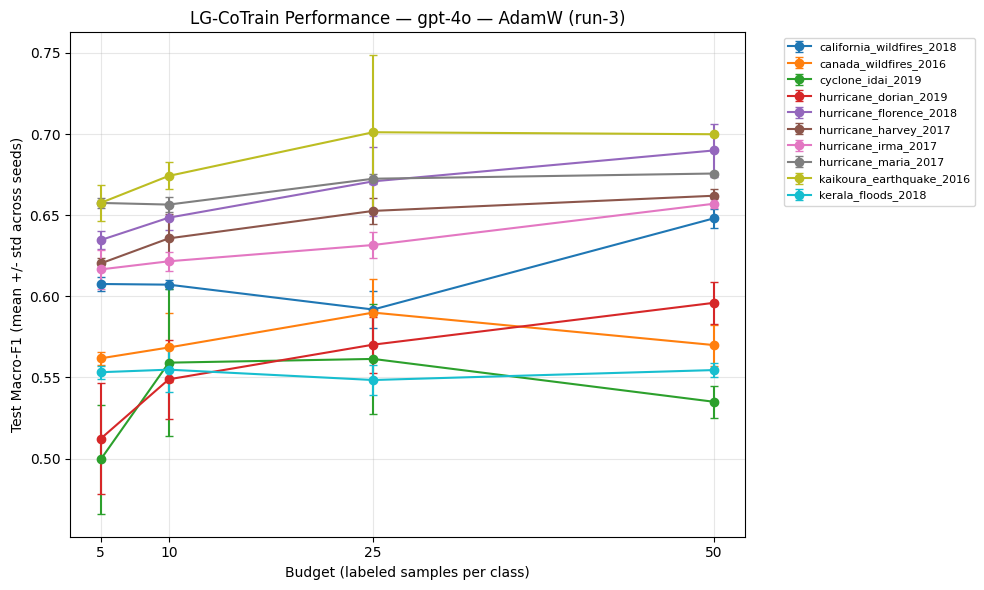

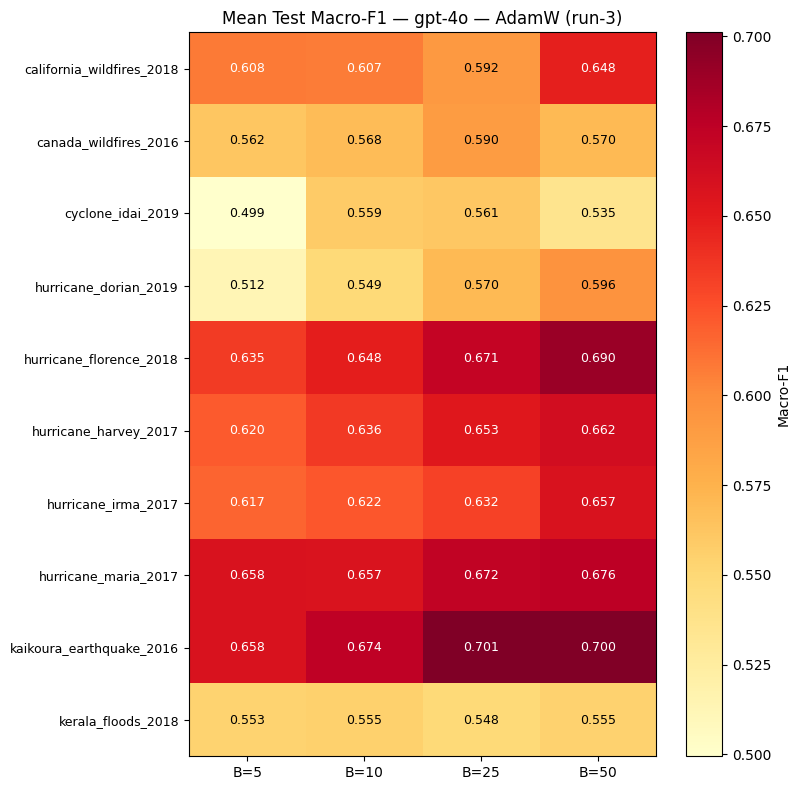

In [6]:
# Line plot: Macro-F1 by budget, one line per event
fig, ax = plt.subplots(figsize=(10, 6))

for event in sorted(summary.keys()):
    means = [summary[event][b]["f1_mean"] or 0 for b in BUDGETS]
    stds = [summary[event][b]["f1_std"] or 0 for b in BUDGETS]
    ax.errorbar(BUDGETS, means, yerr=stds, marker="o", capsize=3, label=event)

ax.set_xlabel("Budget (labeled samples per class)")
ax.set_ylabel("Test Macro-F1 (mean +/- std across seeds)")
ax.set_title(f"LG-CoTrain Performance — {PSEUDO_LABEL_SOURCE} — AdamW (run-3)")
ax.set_xticks(BUDGETS)
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Heatmap: events (rows) x budgets (columns), colored by mean macro-F1
events_sorted = sorted(summary.keys())
heatmap_data = np.zeros((len(events_sorted), len(BUDGETS)))

for i, event in enumerate(events_sorted):
    for j, b in enumerate(BUDGETS):
        val = summary[event][b]["f1_mean"]
        heatmap_data[i, j] = val if val is not None else 0

fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(heatmap_data, cmap="YlOrRd", aspect="auto")

ax.set_xticks(range(len(BUDGETS)))
ax.set_xticklabels([f"B={b}" for b in BUDGETS])
ax.set_yticks(range(len(events_sorted)))
ax.set_yticklabels(events_sorted, fontsize=9)
ax.set_title(f"Mean Test Macro-F1 — {PSEUDO_LABEL_SOURCE} — AdamW (run-3)")

for i in range(len(events_sorted)):
    for j in range(len(BUDGETS)):
        val = heatmap_data[i, j]
        color = "white" if val > 0.6 else "black"
        ax.text(j, i, f"{val:.3f}", ha="center", va="center", color=color, fontsize=9)

fig.colorbar(im, ax=ax, label="Macro-F1")
plt.tight_layout()
plt.show()

In [ ]:
from lg_cotrain.dashboard import collect_all_metrics, generate_html

metrics = collect_all_metrics(RESULTS_ROOT)
html = generate_html(metrics, RESULTS_ROOT)
dashboard_path = Path(RESULTS_ROOT) / "dashboard.html"
dashboard_path.parent.mkdir(parents=True, exist_ok=True)
dashboard_path.write_text(html)
print(f"Dashboard written to: {dashboard_path}")
print(f"Metrics loaded: {len(metrics)} experiments")

## Summary

This notebook ran all 120 experiments using the updated pipeline with:
- **Optimizer**: AdamW (weight_decay=0.01)
- **LR scheduler**: Linear with 10% warmup
- **Stopping strategy**: baseline (patience=5 on ensemble dev macro-F1)
- **Parallel execution**: 2 GPUs (round-robin assignment)
- **Other hyperparameters**: Paper defaults (lr=2e-5, batch_size=32, etc.)

Results are stored in `results/gpt-4o/test/run-3/`.

### CLI equivalent
```bash
python -m lg_cotrain.run_experiment \
    --events california_wildfires_2018 canada_wildfires_2016 cyclone_idai_2019 \
            hurricane_dorian_2019 hurricane_florence_2018 hurricane_harvey_2017 \
            hurricane_irma_2017 hurricane_maria_2017 kaikoura_earthquake_2016 \
            kerala_floods_2018 \
    --pseudo-label-source gpt-4o \
    --stopping-strategy baseline \
    --weight-decay 0.01 \
    --warmup-ratio 0.1 \
    --num-gpus 2 \
    --output-folder results/gpt-4o/test/run-3
```